# Deployment of Nerual Models

## Load Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from urllib.parse import urljoin
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

## Define Functions for model construction

### Gen_Model
This function takes in all the parameters required to construct, compile, and return a complete keras neural network model. This can be used directly with input parameters to build a single model, or used with a hyperparameter tuner.

In [2]:
# General model builder
def Gen_Model(input_shape, output_shape,
              num_hl=1, hl_width=500, hl_activation='relu', resid=False,
              dropout_rate=0.2, learning_rate=0.001):
    # Build the input layer
    x = y = keras.layers.Input(shape=input_shape)
    # Build the hidden layers
    y = keras.layers.Dropout(dropout_rate)(y)
    y = keras.layers.Dense(hl_width, activation=hl_activation)(y)
    if num_hl > 1: # Single hidden layer
        for idx in range(num_hl-1):
            if resid == False:
                y = keras.layers.Dropout(dropout_rate)(y)
                y = keras.layers.Dense(hl_width, activation=hl_activation)(y)
            else: # Optionally add hidden layers
                old_y = y
                y = keras.layers.Dropout(dropout_rate)(y)
                y = keras.layers.Dense(hl_width, activation=hl_activation)(y)
                y = keras.layers.Add()([old_y,y])
                y = keras.layers.LayerNormalization()(y)
    # Build the output layer
    y = keras.layers.Dense(output_shape, activation='softmax')(y)
    # Compile the model
    model = keras.Model(x,y)
    model.compile(optimizer=keras.optimizers.Nadam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

### Gen_Model_Args
Function that takes in a set of characters specifiying the configuration of the experiment, namely what data and targets are we using, and what type of architecture and model size are we using. The values governing the structure of the models were chosen after some initial experimentation. It is encouraged to try tweaking what values are assigned to a "Small" architecture, just as long as the number of parameters is somewhat consistent across architecture types of the same size.

**Note that the Flat architecture does not have a Medium Size**

In [3]:
# feat: feature data being used
# trgt: targets being used
# arch: 'R' -> Residual structure (deep + residual)
#       'D' -> Deep only structure
#       'F' -> Flat structure
# size: 'S' -> Small
#       'M' -> Medium (Not available for flat structure)
#       'L' -> Large
def Gen_Model_Args(data, trgt, arch, size):
    arg_data = dict()
    # Set input and output shape
    arg_data['input_shape'] = data.shape[1:]
    arg_data['output_shape'] = trgt.shape[1]
    # Set Residual structure
    if arch == 'R':
        arg_data['resid'] = True
    else:
        arg_data['resid'] = False
    # Set layer structure
    if arch == 'R' or arch == 'D':
        if size == 'S':
            arg_data['num_hl'] = 3
            arg_data['hl_width'] = 150
        elif size == 'M':
            arg_data['num_hl'] = 4
            arg_data['hl_width'] = 200
        elif size == 'L':
            arg_data['num_hl'] = 5
            arg_data['hl_width'] = 250
    elif arch == 'F':
        arg_data['num_hl'] = 1
        if size == 'S':
            arg_data['hl_width'] = 500
        elif size == 'L':
            arg_data['hl_width'] = 1000
    return arg_data

## Optional GPU setup
Uncomment the line with the device you wish to use

In [4]:
# Setup GPUs
devices = tf.config.get_visible_devices()
tf.config.set_visible_devices(devices[0:1]+devices[1:2])
# strategy = tf.distribute.OneDeviceStrategy('gpu:0')
strategy = tf.distribute.OneDeviceStrategy('cpu:0')

2022-12-07 13:38:23.922812: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-07 13:38:23.922851: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-07 13:38:23.922894: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-irs2e): /proc/driver/nvidia/version does not exist
2022-12-07 13:38:23.923917: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Parameters for the Experiment
Set which dataset you wish to use, the number of features, the architecture, and the size of the model. **All values must be strings**

**'F' architecture and 'S' size cannot be used together**

In [5]:
# Assign arguments

# "X" for xapi, "P" for portuguese
dataset      = 'P'

# [0, 10, 3], for all, 10, or 3 features
features     = '0'

# "F" for flat, "D" for deep, "R" for residual
architecture = 'D'

# "S" for small, "M" for medium, "L" for large
size         = 'M'

## Get the Data

This block builds the url to request the data from a server. The dataset is relatively small

In [6]:
# Construct the download URLS
base_url = "https://www.cs.mtsu.edu/~irs2e/data/"
X_url = "X_"
Y_url = ""
if dataset == "X": # xapi data
    Y_url = urljoin(base_url, "Y_xapi.csv")
    X_url += "xapi"
else: # port data
    Y_url = urljoin(base_url, "Y_port.csv")
    X_url += "port"

if features == "0":
    X_url += ".csv"
elif features == "3":
    X_url += "_3.csv"
elif features == "10":
    X_url += "_10.csv"

Here we load the data in the scope of the strategy we chose. The data is cleaned and the targets are converted to a sparse categorical form. Then the data is randomly shuffled and split 80/20.

In [7]:
with strategy.scope():
    # Get the Data
    X_url = urljoin(base_url, X_url)
    Y_url = urljoin(base_url, Y_url)
    X = pd.read_csv(X_url).drop("Unnamed: 0", axis=1)
    Y = LabelBinarizer().fit_transform(pd.read_csv(Y_url).drop("Unnamed: 0", axis=1))

    # Shuffle the data
    samples = X.shape[0]
    shuffle_idxs = np.random.permutation(samples)
    X_sh = X.iloc[shuffle_idxs,:]
    Y_sh = Y[shuffle_idxs,:]

    # Split the data
    X_tr, X_te, Y_tr, Y_te = train_test_split(X_sh, Y_sh, test_size=0.2)

## Build the Model

Here we get the necessary arguments for our model builder by passing in our dataset and configuration values to Gen_Model_Args. The resulting "args" object is a dictionary containing some of the arguments needed to build the model, changed to automatically match the dataset, architecture, and size specified above.

The Activation function, dropout rate, and learning rate are all provided directly, being the result of an earlier parameter search done with keras tuner.

In [8]:
with strategy.scope():
    # Get the args for the model builder
    args = Gen_Model_Args(X_tr, Y_tr, architecture, size)

    # Build the model
    model = Gen_Model(args['input_shape'],
                      args['output_shape'],
                      args['num_hl'],
                      args['hl_width'],
                      'tanh',              # Activation function
                      args['resid'],
                      0.2,                 # Dropout Rate
                      0.001)               # Learning Rate

## Run the Model

Here we run the model, specifying 100 epochs as the high end of the model, but also adding a, Early Stopping callback that detects when the validation loss is no longer improving. The validation split is set to 0.15 since our data set is very small to begin with. The patience and validation split values can be experimented with to determine which perform the best.

In [9]:
with strategy.scope():
    # Fit the model
    stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_tr, Y_tr,
                        epochs=100,
                        validation_split=0.15,
                        callbacks=[stop_early],
                        verbose=0)

2022-12-07 13:38:26.192787: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_184"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020FlatMapDataset:4"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT


## Get and Print Output

In [10]:
with strategy.scope():
    # Get the test accuracy
    acc = model.evaluate(X_tr, Y_tr)[1]

    # print output
    print("Training accuracy:",*["%.8f"%(x) for x in history.history['accuracy']])
    print("Training loss:",*["%.8f"%(x) for x in history.history['loss']])
    print("Validation accuracy:",*["%.8f"%(x) for x in history.history['val_accuracy']])
    print("Validation loss:",*["%.8f"%(x) for x in history.history['val_loss']])
    print("Test accuracy:", acc)

10/10 [==============================] - 0s 3ms/step - loss: 1.2222 - accuracy: 0.4842
Training accuracy: 0.30223879 0.38059703 0.35074627 0.38805971 0.42910448 0.36940297 0.44029850 0.47761193 0.43656716 0.45149255 0.42910448 0.47388059 0.52985072
Training loss: 1.60754919 1.48896885 1.47412527 1.40789580 1.33960307 1.41460168 1.35555661 1.26058781 1.28027213 1.29115140 1.28315055 1.25923061 1.27112091
Validation accuracy: 0.29166666 0.29166666 0.31250000 0.22916667 0.27083334 0.25000000 0.16666667 0.39583334 0.29166666 0.25000000 0.29166666 0.27083334 0.20833333
Validation loss: 1.64155543 1.65110695 1.66703260 1.63083458 1.71882403 1.83545029 1.74379921 1.59744871 1.81649745 1.91371214 1.70522249 1.75679362 1.81425512
Test accuracy: 0.48417720198631287


2022-12-07 13:38:30.550726: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_3292"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:214"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODU

## Store the Results

Stores the results of this run as a unique txt file combining the specifiers for the dataset, number of features, architecture, and size to create the file name. Note, this overwrites by default to avoid mixing runs where you tweak other parameters that do not affect the file name.

In [11]:
my_dir = os.getcwd()
run_results_fp = os.path.join(my_dir, 'Results', dataset+features+architecture+size+'.txt')
with open(run_results_fp, 'w') as f:
    f.write("Training accuracy: " + ' '.join(["%.8f"%(x) for x in history.history['accuracy']]) + "\n")
    f.write("Training loss: " + ' '.join(["%.8f"%(x) for x in history.history['loss']]) + "\n")
    f.write("Validation accuracy: " + ' '.join(["%.8f"%(x) for x in history.history['val_accuracy']]) + "\n")
    f.write("Validation loss: " + ' '.join(["%.8f"%(x) for x in history.history['val_loss']]) + "\n")
    f.write("Test accuracy: " + str(acc))

## Plot the Results
This will plot the results of the current run

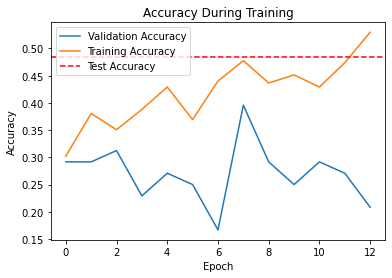

In [12]:
plt.plot(np.arange(0,len(history.history['val_accuracy'])),
         history.history['val_accuracy'],
         label='Validation Accuracy')
plt.plot(np.arange(0,len(history.history['accuracy'])),
         history.history['accuracy'],
         label='Training Accuracy')
plt.axhline(y = acc, color = 'r', linestyle = '--', label="Test Accuracy")
plt.title('Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

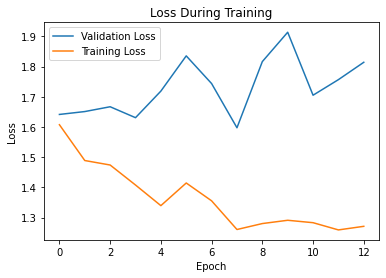

In [13]:
plt.plot(np.arange(0,len(history.history['val_loss'])),
         history.history['val_loss'],
         label='Validation Loss')
plt.plot(np.arange(0,len(history.history['loss'])),
         history.history['loss'],
         label='Training Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()